In [1]:
# korekta błędu w Keras po zmianie w bibliotece numpy
import numpy as np
np_load_old = np.load
np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)

# wyłączenie ostrzeżeń
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# Przykład klasyfikacji wieloklasowej: klasyfikacja krótkich artykułów prasowych


W poprzednim podrozdziale przedstawiłem klasyfikację wektorów przy podziale na dwie rozłączne klasy za pomocą ściśle połączonej sieci neuronowej. Co się dzieje, gdy mamy więcej klas?

W tym podrozdziale zbudujemy sieć klasyfikującą doniesienia prasowe Agencji Reutera na 46 niezależnych tematów. Podział ma być dokonany na wiele grup, a więc mamy tym razem do czynienia z problemem klasyfikacji wieloklasowej. Każdy element zbioru danych może być przypisany tylko do jednej kategorii, a więc problem ten możemy określić mianem jednoetykietowej klasyfikacji wieloklasowej. Gdyby element zbioru danych mógł należeć jednocześnie do wielu kategorii (w tym przypadku do wielu tematów), to mielibyśmy do czynienia z problemem wieloetykietowej klasyfikacji wieloklasowej.



## Zbiór danych Agencji Reutera


W tym podrozdziale będziemy pracować nad zbiorem danych Agencji Reutera — zestawem krótkich informacji prasowych dotyczących określonego tematu, które zostały opublikowane przez tę agencję w 1986 r. Jest to prosty i popularny zbiór danych, doskonale nadający się do eksperymentowania z klasyfikacją tekstu. Zbiór ten zawiera 46 różnych tematów. Do niektórych z nich należy o wiele więcej informacji prasowych niż do innych, ale każdy z tematów ma przynajmniej 10 przykładów w treningowym zbiorze danych.

Zbiór Agencji Reutera, podobnie jak zbiory IMDB i MNIST, wchodzi w skład pakietu Keras. Przyjrzyjmy się jego zawartości.



In [3]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)


Podobnie jak w przypadku zbioru IMDB stosujemy argument num_words=10000, który ogranicza nasze działania do 10 000 słów występujących najczęściej w analizowanym zbiorze danych.

Dysponujemy 8982 przykładami treningowymi i 2246 przykładami testowymi:


In [4]:
len(train_data)

8982

In [5]:
len(test_data)

2246

Każdy przykład jest listą wartości całkowitoliczbowych (indeksów słów) — takie samo rozwiązanie zostało zaprezentowane w przykładzie zbioru IMDB:

In [6]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Poniższy kod umożliwia odkodowanie słów (możesz go uruchomić w celu zaspokojenia swojej ciekawości dotyczącej treści).

In [7]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Kod dekodujący recenzję. Zauważ, że indeksy są przesunięte o 3, ponieważ pod indeksami o numerach 0, 1 i 2 
# znajdują się indeksy symbolizujące „wypełnienie”, „początek sekwencji” i „nieznane słowo”.
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [8]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

Tabela etykiet przykładów zawiera wartości całkowitoliczbowe znajdujące się w zakresie od 0 do 45 (są to indeksy tematów):

In [9]:
train_labels[10]

3

## Przygotowywanie danych

Dane możemy zamienić na wektory za pomocą tego samego kodu, z którego korzystaliśmy w poprzednim przykładzie.

In [10]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Zbiór treningowy w postaci wektora.
x_train = vectorize_sequences(train_data)
# Zbiór testowy w postaci wektora.
x_test = vectorize_sequences(test_data)


Operację przekształcania etykiet na wektor można przeprowadzić na dwa sposoby: poprzez rzutowanie listy etykiet na tensor wartości całkowitoliczbowych lub poprzez kodowanie z gorącą jedynką. Kodowanie z gorącą jedynką jest używane zwykle w przypadku danych kategorialnych — często określa się je mianem kodowania kategorialnego. Szczegółowe wyjaśnienie tego algorytmu kodowania znajdziesz w podrozdziale 6.1. W tym przypadku kodowanie z gorącą jedynką przeprowadzone na zbiorze etykiet będzie polegało na osadzeniu każdej etykiety w formie wektora wypełnionego samymi zerami z liczbą 1 umieszczoną w miejscu indeksu etykiety. Przyjrzyj się kodowi implementującemu ten sposób kodowania:

In [11]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Etykiety zbioru treningowego w postaci wektora.
one_hot_train_labels = to_one_hot(train_labels)
# Etykiety zbioru testowego w postaci wektora.
one_hot_test_labels = to_one_hot(test_labels)

Operację tę można wykonać za pomocą kodu wbudowanego w pakiet Keras (jego działanie widzieliśmy już podczas pracy nad zbiorem MNIST):

In [12]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Budowanie sieci


Problem klasyfikacji tematów przypomina nieco problem klasyfikacji recenzji filmów: w obu sytuacjach próbujemy dokonać klasyfikacji krótkiego fragmentu tekstu. Tym razem mamy dodatkowe ograniczenie: liczba klas wyjściowych wzrosła z 2 do 46. W związku z tym przestrzeń wyjściowa ma o wiele więcej wymiarów.

W przypadku stosowanego wcześniej stosu warstw Dense każda warstwa ma dostęp tylko do informacji wygenerowanych przez poprzednią warstwę. Jeżeli jakaś informacja ważna z punktu widzenia klasyfikacji zostanie pominięta przez którąś z warstw, to nie ma możliwości jej odzyskania przez kolejne warstwy. Każda warstwa może potencjalnie stać się informacyjnym wąskim gardłem. W poprzednim przykładzie stosowaliśmy warstwy pośrednie o 16 wymiarach, ale przestrzeń 16 wymiarów może być zbyt ograniczona, aby nauczyć się rozdzielania danych na 46 różnych klas. Tak małe warstwy mogą stać się wąskimi gardłami, przez które nie będą przechodziły dalej ważne informacje.

W związku z tym będziemy tworzyli większe warstwy. Zacznijmy od 64 jednostek.


In [24]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64,activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))


Warto zwrócić uwagę na jeszcze dwie rzeczy związane z tą architekturą:

* Sieć jest zakończona warstwą Dense o rozmiarze równym 46. W związku z tym każda próbka danych wejściowych spowoduje wygenerowanie przez sieć wektora o 46 wymiarach. Każdy element tego wektora (każdy jego wymiar) będzie zawierał informację odwołującą się do innej klasy.
* W ostatniej warstwie zastosowano funkcję aktywacji softmax. Rozwiązanie to widzieliśmy w przykładzie zbioru MNIST. Dzięki niemu sieć będzie zwracała rozkład prawdopodobieństwa 46 różnych klas — dla każdej próbki wejściowej sieć wygeneruje 46-wymiarowy wektor wyjściowy, w którym element output[i] jest prawdopodobieństwem tego, że próbka należy do klasy i. Wszystkie 46 wyników po zsumowaniu da wartość 1.

W tej sytuacji najlepiej jest skorzystać z funkcji straty w postaci kategorialnej entropii krzyżowej (categorical_crossentropy). Funkcja ta mierzy odległość między dwoma rozkładami prawdopodobieństw: rozkładem prawdopodobieństw zwróconych przez sieć i rozkładem prawdopodobieństw określanym przez etykiety. Minimalizacja odległości między tymi rozkładami pozwala na trenowanie sieci w celu zwracania wartości jak najbardziej zbliżonych do prawdziwych etykiet.

In [25]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Walidacja modelu

Odłączmy 1000 próbek od treningowego zbioru danych w celu użycia ich w charakterze zbioru kontrolnego.

In [26]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Czas uruchomić trenowanie sieci trwające 20 epok.

In [27]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 145us/step - loss: 2.7590 - acc: 0.5174 - val_loss: 1.8205 - val_acc: 0.6430
Epoch 2/20
7982/7982 [==============================] - 1s 121us/step - loss: 1.4592 - acc: 0.7101 - val_loss: 1.3284 - val_acc: 0.7180
Epoch 3/20
7982/7982 [==============================] - 1s 127us/step - loss: 1.0643 - acc: 0.7740 - val_loss: 1.1456 - val_acc: 0.7600
Epoch 4/20
7982/7982 [==============================] - 1s 122us/step - loss: 0.8349 - acc: 0.8224 - val_loss: 1.0660 - val_acc: 0.7740
Epoch 5/20
7982/7982 [==============================] - 1s 124us/step - loss: 0.6673 - acc: 0.8588 - val_loss: 0.9706 - val_acc: 0.7980
Epoch 6/20
7982/7982 [==============================] - 1s 121us/step - loss: 0.5339 - acc: 0.8896 - val_loss: 0.9409 - val_acc: 0.8020
Epoch 7/20
7982/7982 [==============================] - 1s 120us/step - loss: 0.4347 - acc: 0.9100 - val_loss: 0.9346 - val_acc: 0.7980


Teraz możemy wyświetlić wykresy krzywych strat i dokładności :

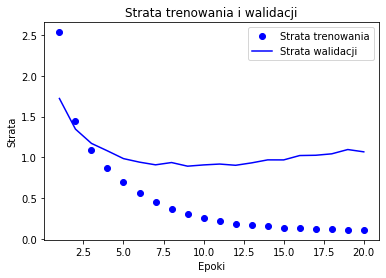

In [20]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

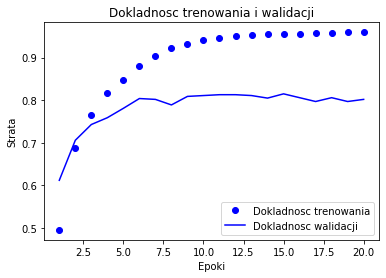

In [21]:
plt.clf()   # Czyszczenie rysunku.

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Dokladnosc trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

Po dziewięciu epokach sieć zaczyna ulegać przeuczeniu. Spróbujmy uruchomić jeszcze raz proces uczenia sieci, ale tym razem ograniczymy jego działanie do 9 epok. Następnie sprawdzimy działanie sieci na testowym zbiorze danych.

In [28]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 1s 148us/step - loss: 2.5771 - acc: 0.4747 - val_loss: 1.6901 - val_acc: 0.6560
Epoch 2/8
7982/7982 [==============================] - 1s 120us/step - loss: 1.3767 - acc: 0.7101 - val_loss: 1.2501 - val_acc: 0.7310
Epoch 3/8
7982/7982 [==============================] - 1s 121us/step - loss: 1.0039 - acc: 0.7833 - val_loss: 1.0851 - val_acc: 0.7580
Epoch 4/8
7982/7982 [==============================] - 1s 122us/step - loss: 0.7828 - acc: 0.8349 - val_loss: 0.9964 - val_acc: 0.7840
Epoch 5/8
7982/7982 [==============================] - 1s 120us/step - loss: 0.6205 - acc: 0.8706 - val_loss: 0.9235 - val_acc: 0.8050
Epoch 6/8
7982/7982 [==============================] - 1s 120us/step - loss: 0.4936 - acc: 0.8998 - val_loss: 0.9241 - val_acc: 0.8070
Epoch 7/8
7982/7982 [==============================] - 1s 121us/step - loss: 0.4009 - acc: 0.9177 - val_loss: 0.8751 - val_acc: 0.8130
Epoch 8

In [29]:
results

[0.9768092473064909, 0.7831700801690137]


Uzyskaliśmy dokładność na poziomie zbliżonym do 80%. W wyważonej klasyfikacji binarnej losowy klasyfikator uzyskałby wynik 50%, ale w tym przypadku jego wynik byłby zbliżony do 19%. Dokładność naszego klasyfikatora wydaje się całkiem dobra, jeżeli porówna się ją z klasyfikatorem przyporządkowującym etykiety w sposób losowy:

In [30]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.1856634016028495

## Generowanie przewidywań dotyczących nowych danych

Możemy zweryfikować zwracanie przez metodę predict naszej instancji modelu rozkładu prawdopodobieństwa wszystkich 46 tematów. Wygenerujmy przewidywania dla wszystkich elementów testowego zbioru danych.

In [ ]:
predictions = model.predict(x_test)

Każdy element zmiennej predictions jest wektorem o długości równej 46:

In [ ]:
predictions[0].shape

Suma wszystkich wartości tego wektora wynosi 1:

In [ ]:
np.sum(predictions[0])

Najwyższa wartość wektora wskazuje przewidywaną klasę — klasę, do której najprawdopodobniej należy dana próbka:

In [ ]:
np.argmax(predictions[0])

## Inne sposoby obsługi etykiet i funkcji straty

Wcześniej pisałem o tym, że drugim sposobem kodowania etykiet jest rzutowanie ich jako tensory całkowitoliczbowe w następujący sposób:

In [ ]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)


Skorzystanie z tego rozwiązania wymaga wprowadzenia jednej zmiany w modelu — wybrania innej funkcji straty. W listingu 3.21 wybraliśmy funkcje categorical_crossentropy, która wymaga podawania etykiet zakodowanych kategorialnie. Przy etykietach mających postać liczb całkowitych powinniśmy użyć funkcji sparse_categorical_crossentropy:

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

Nowa funkcja straty z punktu widzenia matematyki działa tak samo jak funkcja categorical_crossentropy, ale wyposażono ją w inny interfejs.

## Dlaczego warto tworzyć odpowiednio duże warstwy pośrednie?


Stwierdziłem wcześniej, że sieć generuje dane wyjściowe mające 46 wymiarów, a więc powinniśmy unikać warstw pośrednich mających mniej niż 46 ukrytych jednostek. Sprawdźmy, co się stanie, jeżeli wprowadzimy do sieci takie informacyjne wąskie gardło. Wprowadźmy do sieci warstwy pośrednie mające mniej niż 46 wymiarów: zacznijmy od przykładowej warstwy z 4 wymiarami.

In [35]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=4,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/4
7982/7982 [==============================] - 2s 204us/step - loss: 2.4179 - acc: 0.4909 - val_loss: 1.6236 - val_acc: 0.6010
Epoch 2/4
7982/7982 [==============================] - 1s 150us/step - loss: 1.3900 - acc: 0.6814 - val_loss: 1.3167 - val_acc: 0.6930
Epoch 3/4
7982/7982 [==============================] - 1s 152us/step - loss: 1.0723 - acc: 0.7443 - val_loss: 1.1611 - val_acc: 0.7350
Epoch 4/4
7982/7982 [==============================] - 1s 150us/step - loss: 0.8567 - acc: 0.7984 - val_loss: 1.0791 - val_acc: 0.7650



Dokładność sieci w procesie walidacji osiąga teraz wartość szczytową na poziomie około 71%, a więc dokładność spadła w skali bezwzględnej o 8%. Wynika to głównie z tego, że sieć stara się skompresować wiele informacji w zbyt małej liczbie wymiarów warstwy pośredniej. Co prawda sieć jest w stanie dokonać podziału na 46 klas, a więc może ona zakodować większość niezbędnych informacji w formie ośmiowymiarowych reprezentacji, ale przestrzeń taka jest zbyt mała, aby umieścić w niej wszystkie informacje.

## Dalsze eksperymenty

* Spróbuj tworzyć większe lub mniejsze warstwy: warstwy zawierające np. po 32 lub 128 jednostek.
* Korzystaliśmy z dwóch ukrytych warstw. Spróbuj utworzyć sieć zawierającą jedną taką warstwę, a następnie sieć składającą się z trzech takich warstw.

## Wnioski


Oto wnioski, które należy wynieść z tego przykładu:

* Podczas klasyfikacji danych na N klas sieć powinna kończyć się warstwą Dense o rozmiarze równym N.
* W razie wystąpienia problemu wieloklasowej klasyfikacji elementów opisywanych przy użyciu jednej etykiety sieć powinna kończyć się funkcją aktywacji softmax, która umożliwi wygenerowanie rozkładu wartości prawdopodobieństw N klas.
* Kategorialna entropia krzyżowa jest prawie zawsze funkcją straty, która powinna być używana podczas pracy z tego typu problemami. Minimalizuje ona odległość między rozkładem prawdopodobieństwa wygenerowanym przez sieć a rozkładem wartości docelowych.
* Podczas klasyfikacji wieloklasowej można korzystać z jednego z dwóch sposobów obsługi etykiet:

    * Kodowania etykiet za pomocą kodowania kategorycznego(kodowania z gorącą jedynką)i używania funkcji categorical_crossentropy jako funkcji straty.*  
    * Kodowania etykiet za pomocą wartości całkowitoliczbowych i używania funkcji sparse_categorical_crossentropy jako funkcji straty.*
    
    
* Jeżeli musisz podzielić dane na dużą liczbę kategorii, to staraj się unikać tworzenia wąskich gardeł blokujących przepływ informacji w postaci zbyt małych warstw pośrednich.